# X-Learner

X-Learner je meta-learner koji predstavlja poboljsanje T-Learnera. U poredjenju sa njim, ovaj je bolji za nebalansirane tretiranu i kontrolnu grupu.

X-Learner se sastoji od 3 faze, i svaka faza ima model(e) koji predvidjaju razlicite zavisne varijable.
1. Prva faza: Ista je kao T-Learner. Prave se 2 ML modela koji predvidjaju ishod, jedan koristi tretirane klijente a drugi kontrolne.
Nakon sto su modeli napravljeni, ITE se racuna.
  - Za klijente koji su dobili tretman, imputovani ITE je stvarni ishod minus counterfactual ishod predvidjen kontrolnim modelom iz prve faze.
  - Za klijente iz kontrolne grupe, imputovani ITE je counterfactual ishod predvidjen tretiranim modelom iz prve faze minus stvarni ishod.
2. Druga faza: Pravimo 2 ML modela koji predvidjaju imputovanu vrednost ITE, jedan model se trenira na tretiranim podacima, a drugi na kontrolnim.
3. Treca faza: kreira propensity model za predvidjanje sklonosti da se dobije tretman. Predvidjeni rezultat se koristi kao tezina za izracunavanje efekta individualnog tretmana ITE.
Konacno ITE ce biti procenjen koriscenjem tezinskog proseka predvidjanja modela u drugoj fazi, koristeci rezultate kao tezine.

In [0]:
# Install package
!pip install causalml

Looking in indexes: https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/simple/
     |████████████████████████████████| 535 kB 41.8 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |▍              

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 42.1 MB 32 kB/s 
     |████████████████████████████████| 536 kB 50.8 MB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp39-cp39-linux_x86_64.whl size=1795502 sha256=ad2d687b93ee64dc19ba13fd8efdbcb1528cc137a7104a4747603d1ffa5f484d
  Stored in directory: /root/.cache/pip/wheels/16/ef/d4/7a35226eab82497e4ce41e48f2b5abc71b69d0863b37671e84
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=afeca83a2742d3589720fe6050adf1c3133afe0c6ae6a3dafbb6d3caaa088a28
  Stored in directory: /root/.cache/pip/wheels/ca/2b/0a/7ce5639f9af8037477db6f113b129bf42c2ccf27bdb880936f
  Created wheel for future: filename=future-0.18.3-py3

In [0]:
# Data processing
import pandas as pd
import numpy as np

# Create synthetic data
from causalml.dataset import synthetic_data

# Visualization
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier

/local_disk0/.ephemeral_nfs/envs/pythonEnv-e693d872-bdd0-491a-b9b3-0d0b5a07dc03/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e693d872-bdd0-491a-b9b3-0d0b5a07dc03/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#depr

Kreiracemo sinteticki skup podataka za uplift model koriscenjem S-Learnera.
Koristimo *synthetic_data* metodu iz paketa *causal_ml* i kreiramo skup podataka sa 5 karakteristika, jednom promenljivom koja predstavlja da li je klijent dobio tretman i jednom kontinualnom varijablom ishoda.
U odnosu na varijablu *treatment* klijenti su podjednako rasporedjeni.

In [0]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a synthetic dataset
y, X, treatment, _, _, _ = synthetic_data(mode=1, n=5000, p=5, sigma=1.0)

# Save the data in a pandas dataframe
df = pd.DataFrame({'y': y, 'X1': X.T[0], 'X2': X.T[1], 'X3': X.T[2], 'X4': X.T[3], 'X5': X.T[4], 'treatment': treatment})

# Check treatment
df['treatment'].value_counts()

Out[3]: 1    2582
0    2418
Name: treatment, dtype: int64

### Data Processing

Skup podataka se na pocetku deli na dva podskupa u zavisnosti od vrednosti *treatment* varijable.

In [0]:
# Keep only the treated units
df_treated = df[df['treatment'] == 1]
# Features
features_treated = df_treated[['X1', 'X2', 'X3', 'X4', 'X5']]
# Dependent variable
y_treated = df_treated[['y']]
# Print data shape
print(f'The feature maxtrix for the treated has {features_treated.shape[0]} records and {features_treated.shape[1]} features.')
print(f'The dependent variable for the treated has {y_treated.shape[0]} records.')


# Keep only the control units
df_control = df[df['treatment'] == 0]
# Features
features_control = df_control[['X1', 'X2', 'X3', 'X4', 'X5']]
# Dependent variable
y_control = df_control[['y']]
# Print data shape
print(f'The feature maxtrix for the control has {features_control.shape[0]} records and {features_control.shape[1]} features.')
print(f'The dependent variable for the control has {y_control.shape[0]} records.')

The feature maxtrix for the treated has 2582 records and 5 features.
The dependent variable for the treated has 2582 records.
The feature maxtrix for the control has 2418 records and 5 features.
The dependent variable for the control has 2418 records.


In [0]:
# Features for all the samples
features = df[['X1', 'X2', 'X3', 'X4', 'X5']]

### X-Learner prva faza modela

Kreiraju se dva ML modela za predvidjanje ishoda, jedan koristi tretirane jedinice, a drugi kontrolne jedinice. 
Izbor modela i podesavanje hiperparametara su vazni za performanse X-Learnera. To je zato sto performanse modela uticu na predvidjanje modela, a samim tim i na tacnost procene individualnog efekta tretmana (ITE).

Mnogi algoritmi ML se mogu koristiti za izgradnju X-Learnera. U ovom primeru cemo koristiti light GBM model. Modeli za 3 faze mogu koristiti razlicite algoritme masinskog ucenja.

In [0]:
# X-learner stage one model for the treated
s1_treated = LGBMRegressor().fit(features_treated, y_treated)

# X-learner stage one model for the control
s1_control = LGBMRegressor().fit(features_control, y_control)

Da bi se izvršila procena efekta tretmana, potrebno je napraviti dva odvojena predviđanja pomoću obučenih modela prve faze:

In [0]:
# Predictions on the control group using the treated model
s1_treated_predict = s1_treated.predict(features_control)
# Predictions on the treated group using the control model
s1_control_predict = s1_control.predict(features_treated)

### X-Learner 2. faza modela na imputiranu vrednost ITE

ITE se izracunavaju posebno za tretiranu i kontrolnu grupu.

Za tretiranu grupu, ITE se izracunava koriscenjem stvarnog ishoda - kontracinjenicni ishod predvidjen kontrolnim modelom.

Za kontrolnu grupu, ITE se izracunava koriscenjem suprotnog ishoda predvidjenog tretiranim modelom minus stvarni ishod.

In [0]:
# Create a column for the predicted outcomes
df_treated['predicted_outcome'] = s1_control_predict
# Create a column for the imputed ite
df_treated['imputed_ite'] =  df_treated.apply(lambda row: row.y - row.predicted_outcome, axis = 1)
# Create a column for the predicted outcomes
df_control['predicted_outcome'] = s1_treated_predict
# Create a column for the imputed ite
df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row.y, axis = 1)

U modelima druge faze, zavisna varijabla je imputirani individualni efekat tretmana ITE.

In [0]:
# Light GBM model for the treated
s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
# Light GBM model for the control
s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

Predvidjaju se 2 vrednosti za svaku vrednost u skupu podataka, jedna koristi tretirani model 2. faze a drugi koristi kontrolni model.

In [0]:
# Predictions using the treated model
s2_treated_predict = s2_treated.predict(features)
# Save the prediction results as a colum in the dataframe
df['s2_treated_predict'] = s2_treated_predict
# Predictions using the control model
s2_control_predict = s2_control.predict(features)
# Save the prediction results as a colum in the dataframe
df['s2_control_predict'] = s2_control_predict

### X-Learner Propensity skor model

Kreiramo propensity model za predvidjanje sklonosti da se dobije tretman. Zavisna varijabla je tretman (1-dobija tretman, 0-ne dobija tretman). Za predvidjanje mozemo koristiti bilo koji binarni model klasifikacije.

In [0]:
# Train the XGBoost model
xgb = XGBClassifier(seed=0).fit(features,df[['treatment']])
# Make predictions
xgb_predict_prob = xgb.predict_proba(features)[:,1]
# Save the prediction results as a colum in the dataframe
df['treatment_propensity_score'] = xgb_predict_prob

### X-Learner ITE

Efekat individualnog tretmana X-Learnera je ponderisani prosek predvidjanja ITE 2. faze. Autori ovog modela predlazu da se koristi propensity score kao tezina ako tretirana i kontrolna grupa imaju priblizno istu velicinu.

Kada je tretirana grupa veoma velika ili veoma mala u poredjenju sa kontrolnom grupom, mozemo koristiti 0 ili 1 kao velicinu.

Posto je nas skup podataka izbalansiran, koristicemo propensity score kao tezinu.

In [0]:
# Calculate the weighted ITE
df['ITE'] = df.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
# Take a look at the data
df.head()

,y,X1,X2,X3,X4,X5,treatment,s2_treated_predict,s2_control_predict,treatment_propensity_score,ITE
0,1.384447,0.374540,0.950714,0.731994,0.598658,0.156019,1,1.067051,1.302064,0.974071,1.295971
1,3.338572,0.155995,0.058084,0.866176,0.601115,0.708073,0,-0.063325,-0.784513,0.018489,-0.076659
2,2.005024,0.020584,0.969910,0.832443,0.212339,0.181825,0,1.158559,0.627020,0.011795,1.152290
3,1.606035,0.183405,0.304242,0.524756,0.431945,0.291229,1,0.884273,0.718746,0.270967,0.839421
4,0.414825,0.611853,0.139494,0.292145,0.366362,0.456070,0,0.536446,0.695746,0.176633,0.564584


Out[13]: array([[<AxesSubplot:title={'center':'ITE'}>]], dtype=object)

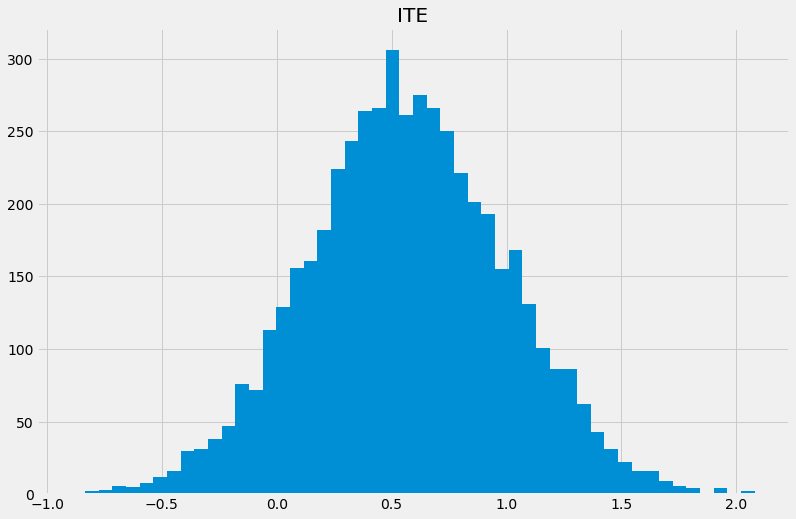

In [0]:
# visualization
df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

In [0]:
# Calculate ATE
ATE = df[['ITE']].mean()
# Print out results
print(f'The average treatment effect (ATE) is {ATE[0]:.2f}')

The average treatment effect (ATE) is 0.57
